In [3]:
from Bio import SeqIO
from keras import backend as K
import tensorflow as tf
from keras import initializers,layers,regularizers
from keras.layers import Dropout
from keras import callbacks
from keras.models import *
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,Activation
import numpy as np
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import interp
from keras.regularizers import l2
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,BatchNormalization,Concatenate
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

Using TensorFlow backend.


In [4]:
def read_fasta(filepath):
    one=list(SeqIO.parse(filepath,'fasta'))
    return one

In [5]:
def onehot(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(seq[0]),len(bases)))
    for i,m in enumerate(seq):
        for l,s in enumerate(m):
    #         print(s)
            if s in bases:
                X[i,l,bases.index(s)] = 1
    return X

In [6]:
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [7]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [8]:
class CapsuleLayer(layers.Layer):
    
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
            initializer=self.kernel_initializer,
            name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True
    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            if i != self.num_routing - 1:
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
        # End: routing algorithm V2, static ------------------------------------------------------------#

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

In [9]:
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding,dropout):
    output = layers.Conv1D(filters=dim_vector * n_channels, kernel_size=kernel_size, strides=strides, padding=padding, 
                           name='primarycap_conv1d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


In [10]:
def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv1=Dropout(0.7)(conv1)
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=16, kernel_size=7, strides=1, padding='valid',dropout=0.2)
    KcrCaps = CapsuleLayer(num_capsule=n_class, dim_vector=8, num_routing=num_routing,kernel_initializer='he_normal', name='KcrCaps')(primarycaps)
    out = Length(name='capsnet')(KcrCaps)
    train_model = Model(x, out)
    return train_model

In [11]:
mode1= CapsNet(input_shape=(29,20),n_class=2,num_routing=3)
mode1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29, 20)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 23, 32)            4512      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 32)            0         
_________________________________________________________________
primarycap_conv1d (Conv1D)   (None, 17, 128)           28800     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 272, 8)            0         
________________________

In [14]:
all_data= read_fasta('Kcr_IND.txt')

In [15]:
positive_ind_data=all_data[0:3343]
negative_ind_data=all_data[3344:6687] 
all_ind_data=positive_ind_data+negative_ind_data # pure data to be used to analysis mutation

In [17]:
all_ind_onehot=onehot(all_ind_data)

In [18]:
label_ind=len(positive_ind_data)*[1]+ len(negative_ind_data)*[0]
label_ind=np.asarray(label_ind)

### load model weights

In [19]:
mode1.load_weights('../1nonhistoneLastepoch_new.h5')

### printing model's layers

In [20]:
for layers in mode1.layers: # imoort the layers of the model 
    print(layers.name)

input_1
conv1
dropout_1
primarycap_conv1d
primarycap_reshape
primarycap_squash
KcrCaps
capsnet


In [33]:
feature_model=Model(input=mode1.input,outputs=mode1.get_layer('KcrCaps').output)

/home/jk/anaconda3/envs/jk/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Kc..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [38]:
features=feature_model.predict(all_ind_onehot)

In [39]:
n,h,w=features.shape

In [40]:
features=features.reshape((n,h*w))

### TSNE_visualization

In [41]:
embedded=TSNE(n_components=2).fit_transform(features)

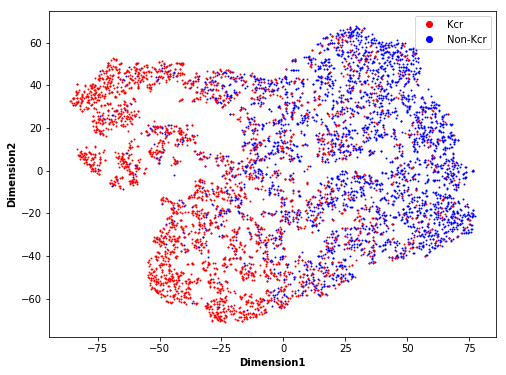

In [42]:
capsul_feature=plt.figure(figsize=(8,6))
for i, labels in enumerate(label_ind):
    if int(labels)==0:
    #if int(np.argmax(labels))==0:
        plt.scatter(embedded[i,0],embedded[i,1],c='r',s=0.9,facecolors='none',label='Non-KCR')
    else:
        plt.scatter(embedded[i,0],embedded[i,1],c='b',s=0.9,facecolors='none',label='KCR')
plt.ylabel('Dimension2',fontweight='bold')
plt.xlabel('Dimension1',fontweight='bold')
l1=plt.Line2D(range(0),range(0),marker='o',color='r',linestyle='')
l2=plt.Line2D(range(0),range(0),marker='o',color='b',linestyle='')
plt.legend((l1,l2),('Kcr','Non-Kcr'),loc='upper right',numpoints=1)
capsul_feature.savefig('t-SNE_capsul_ind_human_kcr.pdf') #for saving figure
plt.show()

### Mutagenesis


In [43]:
def onehot2(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(bases)))
    for i,m in enumerate(seq):
        if m in bases:
            X[i,bases.index(m)] = 1
    return X

In [45]:
input_ref_seq = onehot2(all_ind_data[0]) # use pure data with A C D....... given above
np.shape(input_ref_seq)


(29, 20)

In [48]:
nts= ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

mutation = np.zeros((len((all_ind_data)),29,20)) # x_train is your original sequence (In ACGT Form)

for k, seq in enumerate((all_ind_data)):
    orig = seq
    input_ref_seq = onehot2(seq)  # seq is your onehot encoded form of sequence
    input_ref_seq = np.expand_dims(input_ref_seq,axis=0)
    pred_y =  mode1.predict(input_ref_seq)
    #ref_pred=np.argmax(pred_y,axis=1
   # ref_pred = mode1.predict(input_ref_seq)[0][0]
    
    
    
    for i in range(29):
        for j, nt in enumerate(nts):
            txt = list(orig)
            txt[i]=nt
            #print(alt_seq)
            
            #alt_seq[i]= nt
            alt_seq = ''.join(txt)
            input_alt_seq = onehot2(alt_seq)
            input_alt_seq = np.expand_dims(input_alt_seq,axis=0)
            alt_pred= mode1.predict(input_alt_seq)
            diff = abs(pred_y[0][1] - alt_pred[0][1])  # you may try the absolute differences
            mutation[k,i,j] = diff
            alt_seq=''



In [49]:
mutagenesis = np.average(mutation,axis=0)

In [50]:
np.save('mutagenesis_new_non_histone',mutagenesis)

### load the trained mutation file using np.load

In [51]:
mutagenesis=np.load('mutagenesis_new_non_histone.npy')

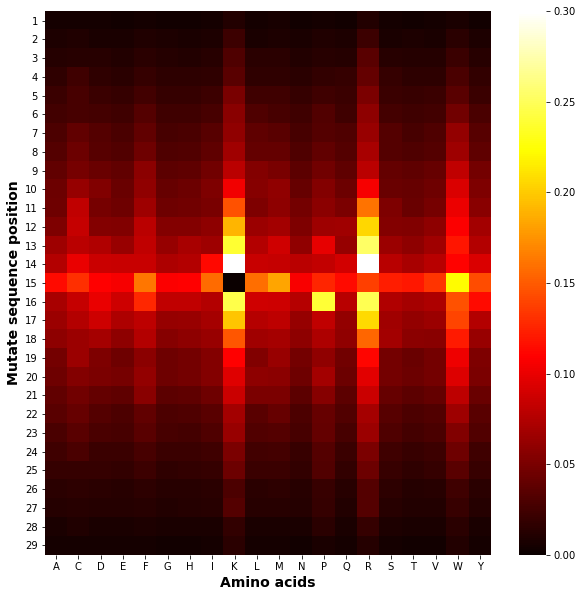

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#mutagenesis = np.load('mutagenesis.npy')
grid_kws = {"height_ratios": (.9, .08), "hspace": .3}

#flights_df = flight.pivot('Sequence', 'Nucleotides') 

x_axis_labels = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = np.arange(1,30,step=1) # labels for y-axis
#mutation = np.random.randn(50, 20)
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(mutagenesis, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="hot", vmax=.3, ax=ax)

plt.yticks(rotation=0) 
plt.xlabel('Amino acids',fontweight='bold',fontsize=14)
plt.ylabel('Mutate sequence position',fontweight='bold',fontsize=14)
fig.savefig("Kcrnh_new_mutation.pdf")

### Motifs captured by different layers
  For the sake of obtaining motifs, the learnt sequence should be converted to sequence motifs/logos to find out Kcr motifs across Kcr sites.


### Conv1d

In [54]:
for layers in mode1.layers: # imoort the layers of the model 
    print(layers.name)

input_1
conv1
dropout_1
primarycap_conv1d
primarycap_reshape
primarycap_squash
KcrCaps
capsnet


In [78]:
f_conv_1D=K.function([mode1.input],[mode1.layers[1].output]) # conv 1 layer
f_primary_conv1D=K.function([mode1.input],[mode1.layers[3].output])#primary caps
capsules=K.function([mode1.input],[mode1.layers[5].output]) #kcrCaps

### Independent_data

In [79]:
positive_ind_data=all_data[0:3343]
negative_ind_data=all_data[3344:6687] # 6687
visu_data=positive_ind_data+negative_ind_data
all_ind_onehot=onehot(visu_data)

In [80]:
positive_vis_data=visu_data
all_positive_onehot=all_ind_onehot

In [81]:
first_conv1d_output=f_conv_1D([all_positive_onehot])
primary_conv1D_outputs=f_primary_conv1D([all_positive_onehot])
capsules_outputs=capsules([all_positive_onehot])

In [82]:
first_conv_seq=[]
for seq in positive_vis_data:
    temp=[]
    for i in range(len(seq)-7+1):
        temp.append(seq[i:i+7].seq)
    first_conv_seq.append(temp)
temp_array=np.asarray(first_conv_seq)

In [83]:
print(first_conv_seq[0])

[Seq('GPEPEAD', SingleLetterAlphabet()), Seq('PEPEADS', SingleLetterAlphabet()), Seq('EPEADSQ', SingleLetterAlphabet()), Seq('PEADSQE', SingleLetterAlphabet()), Seq('EADSQEQ', SingleLetterAlphabet()), Seq('ADSQEQV', SingleLetterAlphabet()), Seq('DSQEQVH', SingleLetterAlphabet()), Seq('SQEQVHP', SingleLetterAlphabet()), Seq('QEQVHPK', SingleLetterAlphabet()), Seq('EQVHPKT', SingleLetterAlphabet()), Seq('QVHPKTG', SingleLetterAlphabet()), Seq('VHPKTGC', SingleLetterAlphabet()), Seq('HPKTGCE', SingleLetterAlphabet()), Seq('PKTGCER', SingleLetterAlphabet()), Seq('KTGCERG', SingleLetterAlphabet()), Seq('TGCERGD', SingleLetterAlphabet()), Seq('GCERGDG', SingleLetterAlphabet()), Seq('CERGDGP', SingleLetterAlphabet()), Seq('ERGDGPD', SingleLetterAlphabet()), Seq('RGDGPDV', SingleLetterAlphabet()), Seq('GDGPDVQ', SingleLetterAlphabet()), Seq('DGPDVQE', SingleLetterAlphabet()), Seq('GPDVQEL', SingleLetterAlphabet())]


In [84]:
def get_values(layer_output,num_of_output_channel,output_size):
    values=np.zeros((len(layer_output[0]),output_size,num_of_output_channel,1))
    for i in range(len(layer_output[0])):
        arg_max=np.argmax(layer_output[0][i,:,:],axis=1)
        max_val=np.max(layer_output[0][i,:,:],axis=1)
        for j,val in enumerate(arg_max):
            values[i,j,val,0]+=max_val[j]
    return values


In [85]:
def get_mottifs(values,filter_size,data,num_of_filters,threshold=None):
    motiffs={}
    temp=[]
    for x in range(len(data)):
        temp1=[]
        for i in range(len(data[0])-filter_size+1):
            temp2=[]
            for j in range(num_of_filters):
                if threshold:
                    if values[x,i,j,0]>=threshold:
                        if j in motiffs.keys():
                            if type(data[x]) is not list:
                                motiffs[j].append(data[x].seq[i:i+filter_size])
                            else:
                                motiffs[j].append(''.join([str(x) for x in data[x][i:i+filter_size]]))
                        else:
                            if type(data[x]) is not list:
                                motiffs[j]=[data[x].seq[i:i+filter_size]]
                            else:
                                motiffs[j]=[''.join([str(x) for x in data[x][i:i+filter_size]])]
                else:
                    temp_mottifs=''.join([str(x) for x in data[x][i:i+filter_size]])
                    temp2.append(temp_mottifs)
            temp1.append(temp2)
        temp.append(temp1)
    if threshold:
        return motiffs
    else:
        return temp

### Sequence learned by Conv1D layer

In [86]:
mottifs_conv1=get_mottifs(get_values(first_conv1d_output,32,23),7,positive_vis_data,32,0.5)

In [125]:
mottifs_conv1[0]

[Seq('RKQTKGL', SingleLetterAlphabet()),
 Seq('RLKTKEN', SingleLetterAlphabet()),
 Seq('KDKEQLR', SingleLetterAlphabet()),
 Seq('KYKRPGY', SingleLetterAlphabet()),
 Seq('KGKSRPK', SingleLetterAlphabet()),
 Seq('KDKIKEN', SingleLetterAlphabet()),
 Seq('RFKGKGK', SingleLetterAlphabet()),
 Seq('KGKGKGN', SingleLetterAlphabet()),
 Seq('QKKEFVK', SingleLetterAlphabet()),
 Seq('QKKEHSK', SingleLetterAlphabet()),
 Seq('ECKEKPS', SingleLetterAlphabet()),
 Seq('KDRTQRK', SingleLetterAlphabet()),
 Seq('REQTRYK', SingleLetterAlphabet()),
 Seq('KGKLKPV', SingleLetterAlphabet()),
 Seq('RTKTKPH', SingleLetterAlphabet()),
 Seq('KEKGKIK', SingleLetterAlphabet()),
 Seq('SKKRKRS', SingleLetterAlphabet()),
 Seq('KKKSKPV', SingleLetterAlphabet()),
 Seq('SEKTKQP', SingleLetterAlphabet()),
 Seq('KGKKYKP', SingleLetterAlphabet()),
 Seq('VRKEKPK', SingleLetterAlphabet()),
 Seq('KDGEKSR', SingleLetterAlphabet()),
 Seq('DKKEGGK', SingleLetterAlphabet()),
 Seq('KSKWGSK', SingleLetterAlphabet()),
 Seq('KEKEKEP', 

In [ ]:
for k in mottifs_conv1.keys():
    f=open('conv_1_seq/'+str(k)+'channel_conv1.txt','w')
    for j,sequence in enumerate(mottifs_conv1[k]):
        f.write('>>'+str(j)+'\n')
        if j==0:
            f.write(str(sequence.seq)+'\n')
        else:
            f.write(str(sequence)+'\n')
    f.close()


### Sequence larned by  PrimaryCaps Conv1D layer

In [89]:
mottifs_primary_conv2=get_mottifs(get_values(primary_conv1D_outputs,128,17),7,first_conv_seq,128,0.5)

### Sequence learned by Each Capsule to KcrCaps

In [93]:
def get_capsule_mottifs(layer_output,sequence,threshold=None):
    mottifs={}
    max_index=np.argmax(layer_output[0],axis=-1)
    h,w,d=layer_output[0].shape
    for i in range(h):
        for j in range(w):
            if threshold:
                if layer_output[0][i,j,max_index[i,j]]>threshold:
                    if j in mottifs.keys():
                        mottifs[j].append(sequence[i,j,max_index[i,j]])
                    else:
                        mottifs[j]=[sequence[i,j,max_index[i,j]]]
            else:
                if j in mottifs.keys():
                        mottifs[j].append(sequence[i,j,max_index[i,j]])
                else:
                    mottifs[j]=[sequence[i,j,max_index[i,j]]]
    return mottifs

In [96]:
a=get_mottifs(get_values(primary_conv1D_outputs,128,17),7,first_conv_seq,128)

In [100]:
b=np.asarray(a)

In [111]:
capsule_mottifs=get_capsule_mottifs(capsules_outputs,np.reshape(np.asarray(get_mottifs(get_values(primary_conv1D_outputs,128,17),7,first_conv_seq,128)),(-1,272,8)),threshold=0.5)

In [112]:
len(capsule_mottifs[9][0]) # total length 

49

#### Motifs learnt by total number of capsuls with a (threshold 0.5 and greater than 0.5.)

In [113]:
len(capsule_mottifs.keys())

187

In [ ]:
### Sequence learnt by capsule 1

In [114]:
capsule_mottifs[1]

['YEYKKRLEYKKRLTYKKRLTLKKRLTLDKRLTLDHRLTLDHELTLDHEK',
 'GGAKKRKGAKKRKKAKKRKKKKKRKKKSKRKKKSYRKKKSYTKKKSYTT',
 'EMEEERLMEEERLREEERLRMEERLRMRERLRMRERLRMREHLRMREHV',
 'EDITFPSDITFPSVITFPSVYTFPSVYVFPSVYVGPSVYVGLSVYVGLK',
 'DGEYIIYGEYIIYTEYIIYTAYIIYTAMIIYTAMAIYTAMALYTAMALR',
 'KLRILRKLRILRKVRILRKVEILRKVEKLRKVEKIRKVEKIDKVEKIDD',
 'QAGGSKKAGGSKKAGGSKKAEGSKKAEQSKKAEQKKKAEQKKKAEQKKK',
 'DTARERATARERAKARERAKLRERAKLQERAKLQIRAKLQIEAKLQIEL',
 'DKERAEKKERAEKNERAEKNVRAEKNVEAEKNVELEKNVELRKNVELRK',
 'YRCGLKKRCGLKKICGLKKIKGLKKIKNLKKIKNDKKIKNDLKIKNDLN',
 'EDKEGKKDKEGKKKKEGKKKMEGKKKMNGKKKMNKKKKMNKNKKMNKNN',
 'LKLQAFSKLQAFSALQAFSAAQAFSAAIAFSAAIEFSAAIESSAAIESC',
 'KVVTYGMVVTYGMAVTYGMANTYGMANLYGMANLLGMANLLTMANLLTG',
 'GEAFVQFEAFVQFAAFVQFASFVQFASQVQFASQEQFASQEIFASQEIA',
 'VNEKKKINEKKKINEKKKINVKKKINVGKKINVGIKINVGIGINVGIGE',
 'DSQLKIKSQLKIKEQLKIKELLKIKELDKIKELDHIKELDHNKELDHNI',
 'KSKGRRFSKGRRFKKGRRFKGGRRFKGKRRFKGKGRFKGKGKFKGKGKG',
 'AMAPSRKMAPSRKFAPSRKFFPSRKFFVSRKFFVGRKFFVGGKFFVGGN',
 'TVTNPKRVTNPKRITNPKRIANPKRI

####  Note
we must devided the sequence by 7 because in the PrimaryCaps we used filter size of 7. Therefore,  49/7=7 lenght of 
sequence to be converted to Kcr motifs. 

### save the learnt sequence (each sequence has of length 7) in fasta format 

In [116]:
for keys in capsule_mottifs.keys():
    f=open('capsule_sequence_none_histone/Caplsule'+str(keys)+'.txt',"w") # make your own file path to save to sequence for motifs
    for i,seq in enumerate(capsule_mottifs[keys]):
        f.write(">>"+str(i)+'0\n')
        f.write(str(seq[:7])+'\n')
        f.write(">>"+str(i)+'1\n')
        f.write(str(seq[7:14])+'\n')
        f.write(">>"+str(i)+'2\n')
        f.write(str(seq[14:21])+'\n')
        f.write(">>"+str(i)+'3\n')
        f.write(str(seq[21:28])+'\n')
        f.write(">>"+str(i)+'4\n')
        f.write(str(seq[28:35])+'\n')
        f.write(">>"+str(i)+'5\n')
        f.write(str(seq[35:42])+'\n')
        f.write(">>"+str(i)+'6\n')
        f.write(str(seq[42::])+'\n')
    f.close()

#### Note: the learnt sequence then can be converted to sequence motifs/logos using online tools such as seq2logo. 